# Libraries Import

In [1]:
import json
import itertools
import re
import os
import pickle

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import  Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Dataset Import

In [6]:
data_rows = []

In [7]:
jsonPathes = ['dataset/intents.json',
              'dataset/intents2.json',
              'dataset/intents3.json',
              'dataset/intents4.json',
              'dataset/intents5.json',
              'dataset/starwarsintents.json']

In [8]:
for jsonPath in jsonPathes:
    with open(jsonPath,'r') as file:
        content  = json.load(file)
        intent = content['intents']
        for item in intent:
            tag = item['tag']
            patterns = item['patterns']
            responses = item['responses']

            for p,r in itertools.product(patterns,responses):
                data_rows.append( { "tag":tag, "pattern":p, "response":r })

In [9]:
df = pd.DataFrame(data_rows)

# Data Exploration

In [10]:
pd.concat([df.head(),df.tail()])

,tag,pattern,response
0,greeting,Hi,Hey there!
1,greeting,Hi,Hello! How can I assist you?
2,greeting,Hi,"Hi, how's it going?"
3,greeting,Hi,"Hey, nice to see you!"
4,greeting,Hi,Hi there! What can I do for you today?
2325,stories,Tell me a story?,It would be too long for me to speak.
2326,stories,Tell me a story?,You would get bored if I do so.
2327,stories,Can you tell me a story.,I can't think of anything right now.
2328,stories,Can you tell me a story.,It would be too long for me to speak.
2329,stories,Can you tell me a story.,You would get bored if I do so.


In [11]:
df.shape

(2330, 3)

In [12]:
df.describe(include='all')

,tag,pattern,response
count,2330,2330,2330
unique,302,1112,516
top,greeting,Hello,"Hi there, how can I help?"
freq,211,28,28


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag       2330 non-null   object
 1   pattern   2330 non-null   object
 2   response  2330 non-null   object
dtypes: object(3)
memory usage: 54.7+ KB


# Data Preprocessing

Types

In [14]:
for c_name in df.columns:
    df[c_name] = df[c_name].astype(str)

Drop patterns containing numbers

In [15]:
items_to_remove = []

In [16]:
for i,msg in enumerate(df['pattern']):
    pat_num = re.compile(r'[0-9]')

    m = re.search(pat_num,msg)

    if m is not None:
        print(f"Remove at i={i:5d}, {msg}")
        items_to_remove.append(i)

df.drop(index=items_to_remove, axis=0, inplace=True)
df.reset_index(inplace=True,drop=True)

Remove at i=  145, What is 15 + 7?
Remove at i=  146, What is 15 + 7?
Remove at i=  147, What is 15 + 7?
Remove at i=  148, Calculate 42 - 18.
Remove at i=  149, Calculate 42 - 18.
Remove at i=  150, Calculate 42 - 18.
Remove at i=  151, What's the result of 8 multiplied by 6?
Remove at i=  152, What's the result of 8 multiplied by 6?
Remove at i=  153, What's the result of 8 multiplied by 6?
Remove at i=  163, Is 23 a prime number?
Remove at i=  164, Is 23 a prime number?
Remove at i=  165, Is 23 a prime number?
Remove at i=  166, Which numbers less than 50 are prime?
Remove at i=  167, Which numbers less than 50 are prime?
Remove at i=  168, Which numbers less than 50 are prime?
Remove at i=  169, Can you tell me if 13 is prime or composite?
Remove at i=  170, Can you tell me if 13 is prime or composite?
Remove at i=  171, Can you tell me if 13 is prime or composite?
Remove at i=  246, Solve the following puzzle: 3 + 3 * 6.
Remove at i=  247, Solve the following puzzle: 3 + 3 * 6.
Re

In [17]:
f"{len(items_to_remove)} row removed"

'44 row removed'

Null values

In [18]:
print(100 * df.isna().sum() / len(df))
df.dropna(inplace=True)
print(100 * df.isna().sum() / len(df))

tag         0.0
pattern     0.0
response    0.0
dtype: float64
tag         0.0
pattern     0.0
response    0.0
dtype: float64


Clean tags & patterns, Tokenization & Lemmitization

In [19]:
def cleanTag(msg):
    pat_char = re.compile(r'[^A-Za-z]')
    pat_spaces = re.compile(r'\s+')

    msg = str(msg).lower()
    msg = msg.strip()
    msg = re.sub(pat_char,' ', msg)
    msg = re.sub(pat_spaces,' ', msg)

    return msg

In [20]:
def cleanPattern(msg):
    pat_char = re.compile(r'[^A-Za-z]')
    pat_spaces = re.compile(r'\s+')

    msg = str(msg).lower()
    msg = msg.strip()
    msg = re.sub(pat_char,' ', msg)
    msg = re.sub(pat_spaces,' ', msg)
    
    tokens = nlp(msg)
    lemma = [token.lemma_ for token in tokens]

    return ' '.join(lemma)

In [21]:
df['tag'] = df['tag'].apply(cleanTag)
df['pattern'] = df['pattern'].apply(cleanPattern)

Duplicates

In [22]:
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True,drop=True)

Data Splitting

In [23]:
QA_df = df.loc[:,['pattern','tag']]
tags_answers = dict()

In [24]:
for i in range(len(df)):
    tag_i = df.loc[i, 'tag']
    answer_i = df.loc[i, 'response']

    l = tags_answers.get(tag_i , list()) 
    l.append(answer_i)  
     
    tags_answers[tag_i] = l

In [25]:
pd.concat([QA_df.head(),QA_df.tail()])

,pattern,tag
0,hi,greeting
1,hi,greeting
2,hi,greeting
3,hi,greeting
4,hi,greeting
2246,tell I a story,stories
2247,tell I a story,stories
2248,can you tell I a story,stories
2249,can you tell I a story,stories
2250,can you tell I a story,stories


In [26]:
tags_answers.keys()

dict_keys(['greeting', 'weather', 'hobbies', 'music', 'movies', 'farewell', 'informal question', 'formal question', 'math formulas', 'motivation', 'team building', 'supporting others', 'overcoming adversity', 'geometry concepts', 'shakespeare poems', 'goodbye', 'thanks', 'noanswer', 'options', 'password reset', 'e mail id', 'blue sreen issue', 'deleted files', 'unsaved document', 'slow computer', 'unexpected shut down', 'printing issues', 'vague', 'virus', 'mouse', 'usb', 'slow internet', 'abstraction', 'error', 'documentation', 'testing', 'datastructure', 'bst', 'dynamic', 'dll', 'lr', 'dt', 'cm', 'bias', 'dr', 'dbms', 'normal', 'relation', 'ai', 'expert', 'rnn', 'supervised', 'hyperparameters', 'bn', 'encryption', 'api', 'cloud computing', 'virtual reality', 'cybersecurity', 'database', 'programming', 'networking', 'data science', 'internet of things', 'blockchain', 'neural networks', 'natural language processing', 'big data', 'devops', 'computer architecture', 'digital logic design'

In [27]:
tags_answers['hobbies']

["As an AI, I don't have hobbies like humans, but I enjoy helping and learning from users like you!",
 "I'm here to assist and chat with you, so feel free to ask me anything!",
 'My main focus is providing useful information and engaging in conversation with you.',
 "As an AI, I don't have hobbies like humans, but I enjoy helping and learning from users like you!",
 "I'm here to assist and chat with you, so feel free to ask me anything!",
 'My main focus is providing useful information and engaging in conversation with you.',
 "As an AI, I don't have hobbies like humans, but I enjoy helping and learning from users like you!",
 "I'm here to assist and chat with you, so feel free to ask me anything!",
 'My main focus is providing useful information and engaging in conversation with you.']

# Data Visualzation

<Axes: xlabel='tag', ylabel='count'>

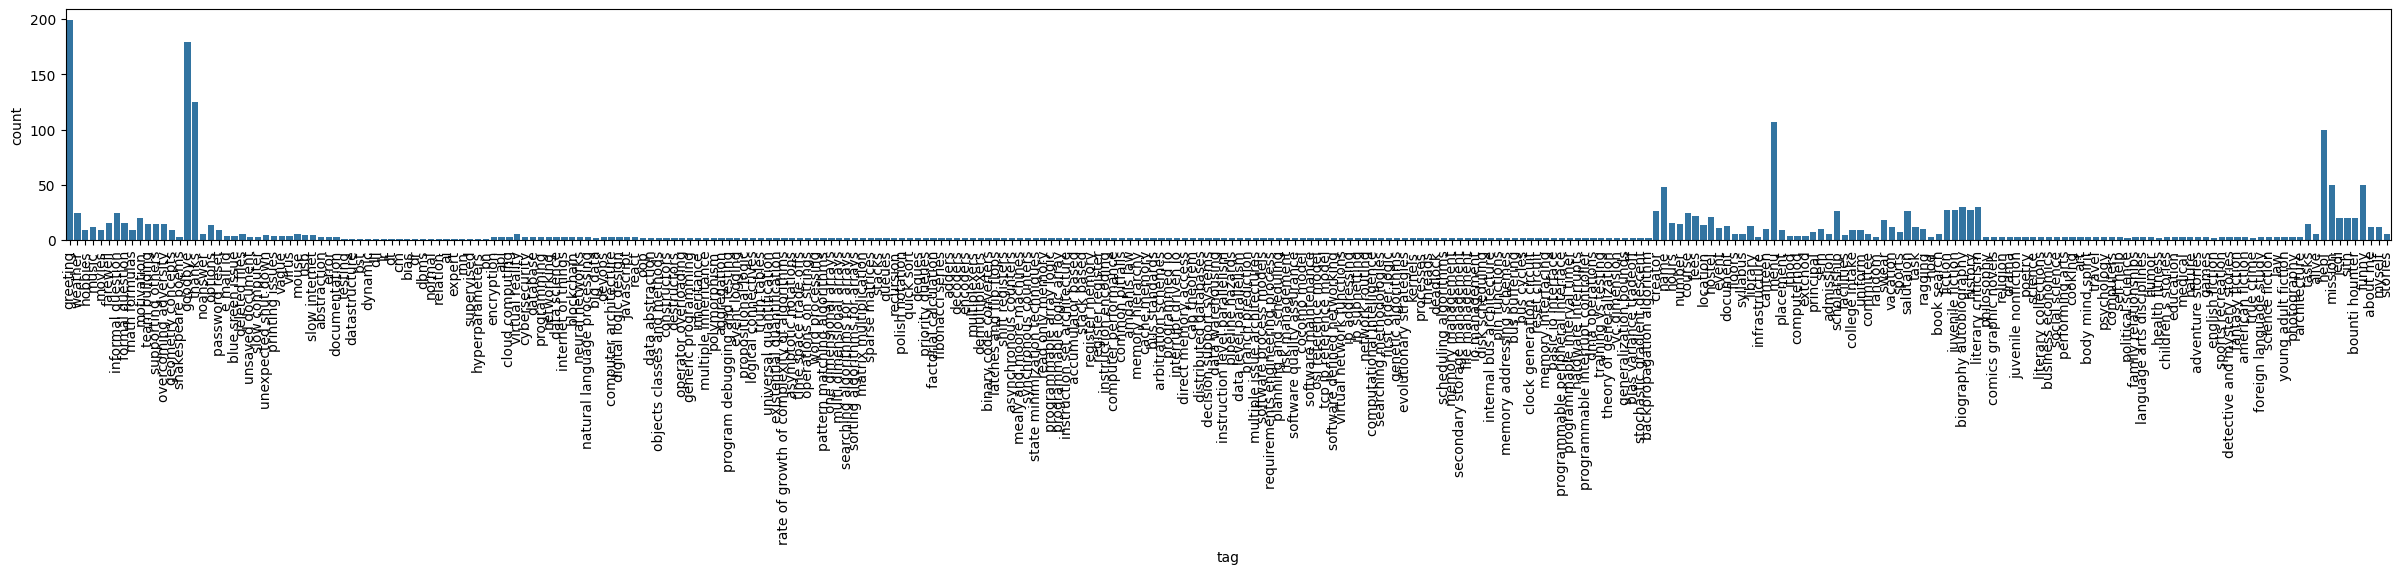

In [28]:
plt.figure(figsize=(30,3))
plt.xticks(rotation =90)
sns.countplot(data=df, x='tag')

Data is highly unbalance

# Before Training

X-Y

In [29]:
corpus = QA_df['pattern'].values
labels = QA_df['tag'].values

Encoding

In [30]:
le = LabelEncoder()
le.fit(labels)
labels_encoded = le.transform(labels)

Tokenization & Padding

In [31]:
MAX_LEN = max(map( lambda x: len(x.split(' ')), corpus)) + 1
print(MAX_LEN)

13


In [32]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

In [33]:
padded_sequences = pad_sequences(sequences, padding='post', maxlen=MAX_LEN)

In [34]:
padded_sequences.shape

(2251, 13)

In [35]:
RANDOM_TEST_INDEX = 500
print(sequences[RANDOM_TEST_INDEX])
print(tokenizer.sequences_to_texts([sequences[RANDOM_TEST_INDEX]]))

[3, 1, 61, 509, 510, 511, 5, 87]
['what be time space trade off in algorithm']


# Model

In [36]:
NUMBER_OF_CLASSES = len(set(labels_encoded))
NUMBER_OF_CLASSES

296

In [37]:
if os.path.exists("simple_chatbot_train_model.h5"):
    print('Load Previous Model')
    model = load_model("simple_chatbot_train_model.h5")
else:
    print('Create New Model')
    model = Sequential(
        [
            Embedding(input_dim= len(tokenizer.word_index) + 1 ,output_dim = 8, input_length= MAX_LEN),

            LSTM(units= 128),
            Dense(units= 64, activation='relu'),
            
            Dense(units= NUMBER_OF_CLASSES , activation = 'softmax')
        ]
    )

Create New Model


c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [38]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [39]:
model.build(padded_sequences.shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (2251, 13, 8)          │         6,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (2251, 128)            │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (2251, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (2251, 296)            │        19,240 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,112 (406.69 KB)

 Trainable params: 104,112 (406.69 KB)

 Non-trainable params: 0 (0.00 B)

Callbacks

In [40]:
early_stopping = EarlyStopping(
    monitor="val_loss", 
    patience=5, 
    restore_best_weights=True)

checkpoint_train = ModelCheckpoint(
    "simple_chatbot_train_model.h5", 
    monitor="loss", 
    save_best_only=True)

checkpoint_val = ModelCheckpoint(
    "simple_chatbot_val_model.h5", 
    monitor="val_loss", 
    save_best_only=True)

Train

In [41]:
model.fit(padded_sequences,
          labels_encoded, 
          epochs= 500, 
          validation_split = 0.2,
          callbacks=[
            #   early_stopping, 
              checkpoint_train,
              checkpoint_val
              ])

Epoch 1/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4322

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.4264 - val_loss: 6.4819
Epoch 2/500
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3890

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3871 - val_loss: 7.7416
Epoch 3/500
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1512

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.1434 - val_loss: 8.2495
Epoch 4/500
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8850

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.8872 - val_loss: 9.5702
Epoch 5/500
51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7291

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.7307 - val_loss: 10.6663
Epoch 6/500
50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.6333

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.6364 - val_loss: 11.8873
Epoch 7/500
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5226

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.5232 - val_loss: 12.5513
Epoch 8/500
52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3716

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3781 - val_loss: 12.6869
Epoch 9/500
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4110

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4061 - val_loss: 15.2858
Epoch 10/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3260

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.3246 - val_loss: 15.9927
Epoch 11/500
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2173

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.2125 - val_loss: 20.1518
Epoch 12/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0668

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.0676 - val_loss: 20.6607
Epoch 13/500
50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9687

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9750 - val_loss: 22.6204
Epoch 14/500
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8870

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8907 - val_loss: 22.1630
Epoch 15/500
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7798

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7810 - val_loss: 23.6848
Epoch 16/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7975

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7969 - val_loss: 26.4389
Epoch 17/500
51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6702

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6701 - val_loss: 25.4444
Epoch 18/500
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6303

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6329 - val_loss: 28.1189
Epoch 19/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5259

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5272 - val_loss: 27.2790
Epoch 20/500
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5434

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5476 - val_loss: 28.6545
Epoch 21/500
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6097

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6046 - val_loss: 29.3554
Epoch 22/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5990 - val_loss: 27.6770
Epoch 23/500
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3521

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3540 - val_loss: 29.6385
Epoch 24/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3214

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3222 - val_loss: 28.2065
Epoch 25/500
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3741

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3730 - val_loss: 30.5135
Epoch 26/500
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3577

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3563 - val_loss: 29.8889
Epoch 27/500
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1864

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1882 - val_loss: 30.0594
Epoch 28/500
52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1124

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1115 - val_loss: 30.2356
Epoch 29/500
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9716

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9765 - val_loss: 31.5636
Epoch 30/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9764 - val_loss: 30.9511
Epoch 31/500
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9929

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9942 - val_loss: 31.0784
Epoch 32/500
51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7854

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7930 - val_loss: 31.4336
Epoch 33/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8178 - val_loss: 31.9438
Epoch 34/500
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8580

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8561 - val_loss: 31.7731
Epoch 35/500
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6003

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6040 - val_loss: 31.9147
Epoch 36/500
51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5607

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5689 - val_loss: 31.0001
Epoch 37/500
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6678

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6642 - val_loss: 32.3110
Epoch 38/500
51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4682

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4731 - val_loss: 32.6867
Epoch 39/500
49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3552

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3699 - val_loss: 36.0960
Epoch 40/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4271 - val_loss: 36.3908
Epoch 41/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4547 - val_loss: 34.7421
Epoch 42/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3939 - val_loss: 36.0356
Epoch 43/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5535 - val_loss: 33.9686
Epoch 44/500
51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2073

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2137 - val_loss: 36.3017
Epoch 45/500
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1446

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1455 - val_loss: 35.6272
Epoch 46/500
50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0772

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0815 - val_loss: 37.3147
Epoch 47/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9982

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9997 - val_loss: 38.2419
Epoch 48/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0648 - val_loss: 38.3185
Epoch 49/500
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9988

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0007 - val_loss: 39.5830
Epoch 50/500
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9789

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9806 - val_loss: 40.8220
Epoch 51/500
48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9753

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9787 - val_loss: 40.0761
Epoch 52/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9590 - val_loss: 41.0849
Epoch 53/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9690 - val_loss: 40.0692
Epoch 54/500
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9895

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9893 - val_loss: 40.2104
Epoch 55/500
48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8551

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8663 - val_loss: 41.1965
Epoch 56/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8762 - val_loss: 41.9341
Epoch 57/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9208 - val_loss: 39.7288
Epoch 58/500
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8916

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8922 - val_loss: 42.7797
Epoch 59/500
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8473

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8466 - val_loss: 42.6464
Epoch 60/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8093 - val_loss: 42.5297
Epoch 61/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8740 - val_loss: 45.8945
Epoch 62/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0493 - val_loss: 41.3467
Epoch 63/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8613 - val_loss: 42.9681
Epoch 64/500
49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7870

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7889 - val_loss: 44.2598
Epoch 65/500
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7528

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7546 - val_loss: 43.9176
Epoch 66/500
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7289

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7311 - val_loss: 44.9093
Epoch 67/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7539 - val_loss: 44.4171
Epoch 68/500
52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7272

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7284 - val_loss: 46.9678
Epoch 69/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7217 - val_loss: 45.9410
Epoch 70/500
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7340

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7341 - val_loss: 47.3099
Epoch 71/500
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6180

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6202 - val_loss: 45.8974
Epoch 72/500
50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6351

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6402 - val_loss: 48.2055
Epoch 73/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7571 - val_loss: 46.3898
Epoch 74/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7103 - val_loss: 46.4122
Epoch 75/500
48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6140

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6172 - val_loss: 47.2923
Epoch 76/500
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5535

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5588 - val_loss: 47.9464
Epoch 77/500
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5757

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5782 - val_loss: 47.0295
Epoch 78/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7136 - val_loss: 49.0609
Epoch 79/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9696 - val_loss: 48.2952
Epoch 80/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8199 - val_loss: 47.5870
Epoch 81/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6620 - val_loss: 46.1618
Epoch 82/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5868 - val_loss: 47.3939
Epoch 83/500
51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5108

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5159 - val_loss: 48.1489
Epoch 84/500
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4844

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4869 - val_loss: 49.5184
Epoch 85/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4963 - val_loss: 50.7679
Epoch 86/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5403 - val_loss: 51.0501
Epoch 87/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5736 - val_loss: 50.7129
Epoch 88/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5808 - val_loss: 52.1684
Epoch 89/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5460 - val_loss: 50.3108
Epoch 90/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5879 - val_loss: 50.7637
Epoch 91/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5370 - val_loss: 50.8708
Epoch 92/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5186 - val_loss: 51.3306
Epoch 93/500
50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4927

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4935 - val_loss: 50.4395
Epoch 94/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4415

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4425 - val_loss: 51.9267
Epoch 95/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5682 - val_loss: 52.7227
Epoch 96/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5182 - val_loss: 54.4349
Epoch 97/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5018 - val_loss: 52.3436
Epoch 98/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4846 - val_loss: 52.7747
Epoch 99/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6071 - val_loss: 55.7341
Epoch 100/500
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4688

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4704 - val_loss: 54.2763
Epoch 101/500
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4213

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4228 - val_loss: 53.8681
Epoch 102/500
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4072

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4110 - val_loss: 54.7109
Epoch 103/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4087

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4092 - val_loss: 55.3101
Epoch 104/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4219 - val_loss: 53.6704
Epoch 105/500
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3964

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3966 - val_loss: 57.3467
Epoch 106/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3560 - val_loss: 54.7803
Epoch 107/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4087 - val_loss: 56.6591
Epoch 108/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6528 - val_loss: 55.0015
Epoch 109/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3369 - val_loss: 54.5789
Epoch 110/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7828 - val_loss: 49.2854
Epoch 111/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5815 - val_loss: 50.1082
Epoch 112/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4551 - val_loss: 53.1078
Epoch 113/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3511 - val_loss: 52.8143
Epoch 114/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5338 - val_loss: 52.6268
Epoch 115/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3975 - val_loss: 52.5001
Epoch 116/500
49/57 ━━━━━━━━━━━━━━━━━━━

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3430 - val_loss: 53.2278
Epoch 117/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3920

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3916 - val_loss: 53.9692
Epoch 118/500
52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3172

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3180 - val_loss: 53.1624
Epoch 119/500
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2948

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2960 - val_loss: 54.6067
Epoch 120/500
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2789

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2796 - val_loss: 54.9888
Epoch 121/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2935 - val_loss: 55.7582
Epoch 122/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3490 - val_loss: 55.1278
Epoch 123/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4770 - val_loss: 56.9300
Epoch 124/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4287 - val_loss: 55.2508
Epoch 125/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4110 - val_loss: 55.4136
Epoch 126/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3272 - val_loss: 54.8312
Epoch 127/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3361 - val_loss: 56.2804
Epoch 128/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2839 - val_loss: 57.5490
Epoch 129/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2586

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2592 - val_loss: 57.0938
Epoch 130/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2677 - val_loss: 56.0593
Epoch 131/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3256 - val_loss: 55.1602
Epoch 132/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3450 - val_loss: 59.3307
Epoch 133/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3759 - val_loss: 54.9838
Epoch 134/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5574 - val_loss: 51.7112
Epoch 135/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4249 - val_loss: 56.2981
Epoch 136/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4205 - val_loss: 56.1953
Epoch 137/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3176 - val_loss: 52.7254
Epoch 138/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3056 - val_loss: 54.8479
Epoch 139/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3297 - val_loss: 52.6370
Epoch 140/500
57/57 ━━━━━━━━━━━━━━━━

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2614 - val_loss: 56.9334
Epoch 144/500
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2782

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2783 - val_loss: 57.3034
Epoch 145/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2809 - val_loss: 55.4346
Epoch 146/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2891 - val_loss: 57.4014
Epoch 147/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2812 - val_loss: 55.4466
Epoch 148/500
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2667

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2669 - val_loss: 57.2808
Epoch 149/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2586 - val_loss: 55.9180
Epoch 150/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2597 - val_loss: 56.4472
Epoch 151/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2832 - val_loss: 56.0181
Epoch 152/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3498 - val_loss: 56.3133
Epoch 153/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4404 - val_loss: 52.8204
Epoch 154/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3053 - val_loss: 55.4400
Epoch 155/500
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2194

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2198 - val_loss: 56.0985
Epoch 156/500
51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2022

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2008 - val_loss: 56.2350
Epoch 157/500
51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1618

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1633 - val_loss: 58.1035
Epoch 158/500
49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1473

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1500 - val_loss: 57.2974
Epoch 159/500
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1388

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1396 - val_loss: 56.6182
Epoch 160/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1686 - val_loss: 56.9188
Epoch 161/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2180 - val_loss: 54.7895
Epoch 162/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5263 - val_loss: 58.3104
Epoch 163/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3255 - val_loss: 56.5204
Epoch 164/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4927 - val_loss: 56.5645
Epoch 165/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4466 - val_loss: 56.6930
Epoch 166/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3052 - val_loss: 55.3789
Epoch 167/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2385 - val_loss: 55.8913
Epoch 168/500
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1515

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1518 - val_loss: 57.2048
Epoch 169/500
50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1016

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1048 - val_loss: 56.1485
Epoch 170/500
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1112

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1113 - val_loss: 56.7047
Epoch 171/500
51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0995

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0996 - val_loss: 56.7925
Epoch 172/500
50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0946

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0952 - val_loss: 57.6286
Epoch 173/500
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0882

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0881 - val_loss: 57.0145
Epoch 174/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0790 - val_loss: 58.5528
Epoch 175/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0884 - val_loss: 57.7557
Epoch 176/500
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0823

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0826 - val_loss: 57.9999
Epoch 177/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0797

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0798 - val_loss: 58.6444
Epoch 178/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0731 - val_loss: 58.4832
Epoch 179/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0791 - val_loss: 58.1982
Epoch 180/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0789 - val_loss: 58.6032
Epoch 181/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0898 - val_loss: 60.3457
Epoch 182/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1165 - val_loss: 59.5489
Epoch 183/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2190 - val_loss: 61.9466
Epoch 184/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4408 - val_loss: 56.2486
Epoch 185/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5898 - val_loss: 58.6535
Epoch 186/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5569 - val_loss: 52.7912
Epoch 187/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3340 - val_loss: 54.5561
Epoch 188/500
57/57 ━━━━━━━━━━━━━━━━

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0658 - val_loss: 54.5678
Epoch 193/500
50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0528

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0545 - val_loss: 54.9667
Epoch 194/500
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0623

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0622 - val_loss: 56.2406
Epoch 195/500
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0502

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0510 - val_loss: 55.7010
Epoch 196/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0658 - val_loss: 55.8332
Epoch 197/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0542

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0543 - val_loss: 56.9918
Epoch 198/500
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0532

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0532 - val_loss: 56.6972
Epoch 199/500
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0503

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0505 - val_loss: 56.2771
Epoch 200/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0466 - val_loss: 57.2398
Epoch 201/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0512 - val_loss: 57.0445
Epoch 202/500
51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0468

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0474 - val_loss: 57.5757
Epoch 203/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0468 - val_loss: 57.3352
Epoch 204/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0482 - val_loss: 57.3529
Epoch 205/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0515 - val_loss: 57.0290
Epoch 206/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0437 - val_loss: 58.5017
Epoch 207/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0771 - val_loss: 58.9530
Epoch 208/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1173 - val_loss: 57.8100
Epoch 209/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7112 - val_loss: 49.5990
Epoch 210/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.3469 - val_loss: 49.6899
Epoch 211/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5834 - val_loss: 47.1188
Epoch 212/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2515 - val_loss: 48.0272
Epoch 213/500
57/57 ━━━━━━━━━━━━━━━

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0468 - val_loss: 52.1848
Epoch 222/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0510 - val_loss: 52.1996
Epoch 223/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0432 - val_loss: 52.5397
Epoch 224/500
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0424

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0425 - val_loss: 53.4719
Epoch 225/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0420 - val_loss: 53.3934
Epoch 226/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0440 - val_loss: 53.7068
Epoch 227/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0437 - val_loss: 54.2184
Epoch 228/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0423 - val_loss: 54.0339
Epoch 229/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0476 - val_loss: 54.5884
Epoch 230/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0375 - val_loss: 54.4472
Epoch 231/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0400 - val_loss: 55.0271
Epoch 232/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0592 - val_loss: 54.4373
Epoch 233/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0746 - val_loss: 54.3891
Epoch 234/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3768 - val_loss: 54.1265
Epoch 235/500
57/57 ━━━━━━━━━━━━━━━

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0505 - val_loss: 52.8376
Epoch 247/500
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0442

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0441 - val_loss: 53.2005
Epoch 248/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0410 - val_loss: 52.9252
Epoch 249/500
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0387

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0389 - val_loss: 53.3422
Epoch 250/500
52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0435

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0433 - val_loss: 53.0896
Epoch 251/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0336 - val_loss: 53.9100
Epoch 252/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0395 - val_loss: 53.8089
Epoch 253/500
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0328

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0332 - val_loss: 53.7803
Epoch 254/500
51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0459

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0453 - val_loss: 53.8045
Epoch 255/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0293 - val_loss: 54.0960
Epoch 256/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0437 - val_loss: 53.5889
Epoch 257/500
50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0412

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0410 - val_loss: 54.3130
Epoch 258/500
51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0330

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0337 - val_loss: 54.0989
Epoch 259/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0354 - val_loss: 54.1720
Epoch 260/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0405 - val_loss: 54.5410
Epoch 261/500
52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0328

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0334 - val_loss: 55.2616
Epoch 262/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0367 - val_loss: 54.7959
Epoch 263/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0342 - val_loss: 55.3301
Epoch 264/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0409 - val_loss: 55.4948
Epoch 265/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0429 - val_loss: 55.4197
Epoch 266/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0413 - val_loss: 54.6989
Epoch 267/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0575 - val_loss: 54.6563
Epoch 268/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4352 - val_loss: 53.0027
Epoch 269/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.3671 - val_loss: 46.7580
Epoch 270/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6486 - val_loss: 46.8016
Epoch 271/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2247 - val_loss: 47.7554
Epoch 272/500
57/57 ━━━━━━━━━━━━━━━

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0369 - val_loss: 53.0028
Epoch 300/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0344 - val_loss: 53.0623
Epoch 301/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0351 - val_loss: 54.4016
Epoch 302/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0897 - val_loss: 56.2076
Epoch 303/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8536 - val_loss: 50.2078
Epoch 304/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5018 - val_loss: 50.2129
Epoch 305/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3257 - val_loss: 49.9030
Epoch 306/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2624 - val_loss: 47.2039
Epoch 307/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2249 - val_loss: 46.7224
Epoch 308/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0974 - val_loss: 49.8406
Epoch 309/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0740 - val_loss: 50.0780
Epoch 310/500
57/57 ━━━━━━━━━━━━━━━

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0345 - val_loss: 52.5486
Epoch 324/500
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0392

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0391 - val_loss: 52.4651
Epoch 325/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0353 - val_loss: 53.2083
Epoch 326/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0355 - val_loss: 53.2682
Epoch 327/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0508 - val_loss: 51.4083
Epoch 328/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0371 - val_loss: 52.6002
Epoch 329/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0382 - val_loss: 52.2734
Epoch 330/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0772 - val_loss: 56.6122
Epoch 331/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2314 - val_loss: 51.6006
Epoch 332/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4452 - val_loss: 50.5622
Epoch 333/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4721 - val_loss: 46.3941
Epoch 334/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2295 - val_loss: 47.8364
Epoch 335/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0359 - val_loss: 53.2898
Epoch 356/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0391 - val_loss: 52.9528
Epoch 357/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0371 - val_loss: 53.6465
Epoch 358/500
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0331

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0333 - val_loss: 53.1978
Epoch 359/500
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0396

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0394 - val_loss: 53.5132
Epoch 360/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0412 - val_loss: 52.8196
Epoch 361/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0364 - val_loss: 53.9220
Epoch 362/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0368 - val_loss: 54.0072
Epoch 363/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0289 - val_loss: 53.9781
Epoch 364/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0335 - val_loss: 53.1294
Epoch 365/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0362 - val_loss: 53.6332
Epoch 366/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0412 - val_loss: 53.2078
Epoch 367/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0532 - val_loss: 54.8539
Epoch 368/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0544 - val_loss: 54.3800
Epoch 369/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5202 - val_loss: 48.8530
Epoch 370/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0325 - val_loss: 48.2183
Epoch 385/500
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0447

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0439 - val_loss: 48.5822
Epoch 386/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0353 - val_loss: 48.1936
Epoch 387/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0381 - val_loss: 48.6435
Epoch 388/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0325 - val_loss: 48.7995
Epoch 389/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0328 - val_loss: 47.6857
Epoch 390/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0497 - val_loss: 49.2518
Epoch 391/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0368 - val_loss: 48.6711
Epoch 392/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0343 - val_loss: 49.3070
Epoch 393/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0352 - val_loss: 49.2839
Epoch 394/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0321 - val_loss: 49.7752
Epoch 395/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0342 - val_loss: 49.0482
Epoch 396/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0297 - val_loss: 49.8134
Epoch 398/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0350 - val_loss: 49.9496
Epoch 399/500
53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0307

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0311 - val_loss: 49.7078
Epoch 400/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0303 - val_loss: 50.2321
Epoch 401/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0376 - val_loss: 49.9209
Epoch 402/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0376 - val_loss: 50.1907
Epoch 403/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0295 - val_loss: 50.8694
Epoch 404/500
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0324

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0325 - val_loss: 50.9394
Epoch 405/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0285 - val_loss: 51.0924
Epoch 406/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0363 - val_loss: 51.4064
Epoch 407/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0387 - val_loss: 51.4701
Epoch 408/500
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0317

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0318 - val_loss: 50.9523
Epoch 409/500
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0340

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0340 - val_loss: 50.8649
Epoch 410/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0296 - val_loss: 51.5395
Epoch 411/500
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0304

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0306 - val_loss: 51.3321
Epoch 412/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0334 - val_loss: 51.7443
Epoch 413/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0326 - val_loss: 51.2832
Epoch 414/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0929 - val_loss: 50.9932
Epoch 415/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9564 - val_loss: 43.6094
Epoch 416/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8266 - val_loss: 40.8777
Epoch 417/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3297 - val_loss: 41.2239
Epoch 418/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1150 - val_loss: 41.8531
Epoch 419/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0805 - val_loss: 41.4947
Epoch 420/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0562 - val_loss: 42.5510
Epoch 421/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0514 - val_loss: 43.5285
Epoch 422/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0277 - val_loss: 46.6189
Epoch 479/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0324 - val_loss: 46.9050
Epoch 480/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0298 - val_loss: 46.8700
Epoch 481/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0269 - val_loss: 47.0588
Epoch 482/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0377 - val_loss: 46.9846
Epoch 483/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0319 - val_loss: 47.2641
Epoch 484/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0496 - val_loss: 46.7401
Epoch 485/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0418 - val_loss: 46.9397
Epoch 486/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0330 - val_loss: 47.1482
Epoch 487/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0404 - val_loss: 47.0534
Epoch 488/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0330 - val_loss: 47.3093
Epoch 489/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0240 - val_loss: 47.8567
Epoch 499/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0281 - val_loss: 47.6041
Epoch 500/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0961 - val_loss: 42.9071


History

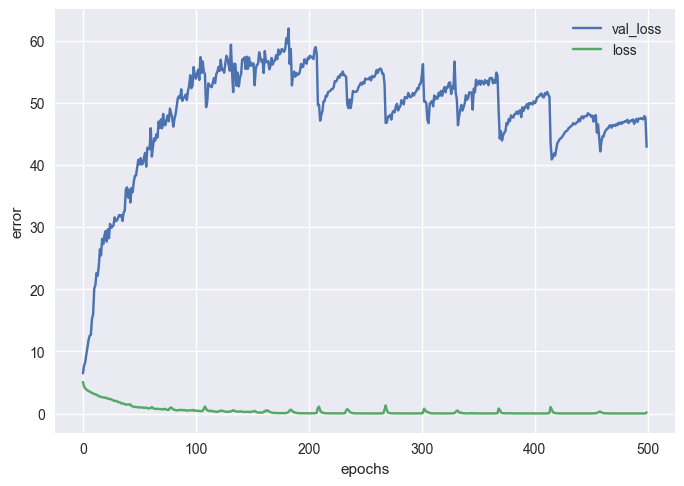

In [93]:
plt.style.use(plt.style.available[12])
plt.xlabel('epochs')
plt.ylabel('error')

plt.plot(
    model.history.history['val_loss'],
    label= "val_loss",
)
plt.plot(
    model.history.history['loss'],
    label= "loss",
)

plt.legend()

# Prediction

In [91]:
def predict(msg):
    msg = cleanPattern(msg)

    sequences = tokenizer.texts_to_sequences([msg])
    padded_sequences = pad_sequences(sequences, padding='post', maxlen=MAX_LEN)

    predictino_prob = model.predict(padded_sequences)

    tag_index = np.argmax( predictino_prob , axis=1 )
    
    tag = le.inverse_transform(tag_index)[0]

    all_responses = tags_answers[tag]

    random_response = np.random.choice(all_responses)

    print(f"Tag: {tag} \nResponse: {random_response} \n")
    

In [92]:
predict('Hello')
predict('Tell me the current weather')
predict('My computer is running too slowly!')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tag: greeting 
Response: Hello, there. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tag: weather 
Response: The weather is sunny and warm today. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tag: slow computer 
Response: Here are my 10 quick tips for things you can do to speed up your PC
1. Cut down on start-up items
2. Uninstall programs you no longer use
3. Clean up your hard drive
4. Clean your browser
5. Scan for and remove malware
6. Adjust for better performance
7. Defrag your hard drive
8. Add more RAM.
9. Upgrade to an SSD drive
10. Don’t shut down, use Hibernate  



# Exporting

In [44]:
def saveObject(obj, file_name: str):
    file_name += '.pickle'
    
    try:
        with open(file_name, 'wb') as file:
            pickle.dump(obj, file)

        print(f"Object successfully saved to {file_name}")

    except Exception as e:
        print(f"Error saving object: {e}")


In [45]:
saveObject(tokenizer,'tokenizer')
saveObject(le,'label_encoder')
saveObject(tags_answers,'tags_answers')

Object successfully saved to tokenizer.pickle
Object successfully saved to label_encoder.pickle
Object successfully saved to tags_answers.pickle


In [46]:
df.to_csv('data_merged.csv')